# Speech emotion recognition 
## using ESN-IP

---



In [ ]:
!pip install opensmile

     |████████████████████████████████| 4.9MB 5.3MB/s 


In [ ]:
# import libraries
import os

import numpy as np
import pandas as pd
import librosa   # to extract speech features
import soundfile  # to read sound file
import glob # to find files
from sklearn.model_selection import train_test_split # for splitting training and testing
from sklearn.metrics import accuracy_score # to measure how good we are
from sklearn.linear_model import Ridge
import math
import scipy.io
import scipy.linalg as la
import random
from scipy.special import softmax

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from numpy import argmax
import matplotlib.pyplot as plt

from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

import opensmile
from itertools import chain



In [ ]:
# download and extract dataset to current directory
def extract_dataset():
  if "download.zip" in os.listdir():
    print("Dataset already exist")

  else:  
    print("Downloading Emo-DB (40.5MB) ...")
    !wget http://emodb.bilderbar.info/download/download.zip
    print("Dataset is downloaded!")
    print("Now extracting the data ...")
    !unzip download.zip
    print("Extracting is done!")

  # determine the path of wav folder
  current_path = os.getcwd()
  print("currect path is ", current_path)
  location = os.path.join(current_path, "wav/")
  print("full path to dataset wav folder: ", location)

  # convert the dataset_files list into panda dataframe for better visualization
  dataset_files = os.listdir(location)
  
  return dataset_files

audio_files = extract_dataset()
# audio_files

In [ ]:
# important for opensmile to workout audio files
!git clone git://git.code.sf.net/p/sox/code sox

Cloning into 'sox'...
remote: Enumerating objects: 21459, done.
remote: Counting objects: 100% (21459/21459), done.
remote: Compressing objects: 100% (6373/6373), done.
remote: Total 21459 (delta 17034), reused 18749 (delta 15002)
Receiving objects: 100% (21459/21459), 7.18 MiB | 11.71 MiB/s, done.
Resolving deltas: 100% (17034/17034), done.


In [ ]:
# Get emotion labels
emotion_encoding = {
  'W': 'Anger',
  'L': 'Bordom',
  'E': 'Disgust',
  'A': 'Anxiety/Fear',
  'F': 'Happienss',
  'T': 'Sadness',
  'N': 'Neutral'
}

def get_emotions(file_name):
  emotion_code = file_name[-1-5]
  emotion_name = emotion_encoding[emotion_code]
  return emotion_name

# prepare open simle
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.Functionals,
)

# append the sound features (the inputs) in x and labels in y
x, y_labels = [], []

for file in glob.glob("wav/*.wav"):
  # extract features opensmile library function
  features = smile.process_file(file)
  x.append(list(chain.from_iterable(features.values.tolist())))

  # from file name get the emotion name
  file_name = os.path.basename(file)
  emotion_name = get_emotions(file_name)
  y_labels.append(emotion_name)


In [ ]:
# # convert x to np.array
# x = np.array(x)
# print(x.shape)
# print("The extracted sound features in numerical format:\n", x)
# print("========================================================\n")
# # Label encoding the output labels into numerical values

# # 1.convert y_labels to np.array
# y_labels = np.array(y_labels)
# # print(y_labels)

# # 2. encode labels to numerical values
# labelencoder = LabelEncoder()
# y_int = labelencoder.fit_transform(y_labels)
# # print(y_int)

# # # 3. reshape y and binary encoded:
# onehot_encoder = OneHotEncoder(sparse=False)

# # # y_int = y_int.reshape(-1,1)
# y_int = y_int.reshape(len(y_int),1)
# y_binary = onehot_encoder.fit_transform(y_int)
# print(y_binary.shape)
# print("The emotions in numerical class form:\n", y_binary)
# y = y_binary

In [ ]:
y_labels = np.array(y_labels).reshape(-1,1)

data = np.hstack((x, y_labels))
data = pd.DataFrame(data)
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,6334,6335,6336,6337,6338,6339,6340,6341,6342,6343,6344,6345,6346,6347,6348,6349,6350,6351,6352,6353,6354,6355,6356,6357,6358,6359,6360,6361,6362,6363,6364,6365,6366,6367,6368,6369,6370,6371,6372,6373
0,3.138430595397949,0.32608696818351746,0.77173912525177,0.37117546796798706,1.0228445529937744,1.6348971128463745,0.6516690850257874,0.6120525598526001,1.2637217044830322,0.040973495692014694,2.8180341720581055,2.7770607471466064,0.751326322555542,0.40678268671035767,2.336169958114624,0.10187499970197678,0.29999998211860657,0.029999999329447746,0.07915323227643967,0.5869565010070801,0.2663043439388275,0.06521739065647125,0.010869565419852734,0.43169400095939636,0.5549450516700745,0.01626613177359104,-1.928302526473999,0.8890398740768433,0.6385982632637024,-0.8565496802330017,0.2729513943195343,4.96591854095459,0.804347813129425,0.45108696818351746,0.6410483717918396,1.256026029586792,1.8243542909622192,0.6149776577949524,0.5683282613754272,1.1833059787750244,...,0.5004666447639465,2.7820193767547607,2.767446994781494,19.865474700927734,0.5172802209854126,118.92865753173828,58.49457931518555,125.8994140625,60.09687042236328,0.6708258390426636,1.7225239276885986,2.2684969902038574,0.09555555135011673,0.05028928071260452,6.935886859893799,0.5750061869621277,2.8024775981903076,2.762502431869507,18.77179718017578,0.4514006972312927,112.94419860839844,51.315372467041016,128.01278686523438,52.08991241455078,0.7008286118507385,1.68239164352417,2.1571836471557617,0.09666667133569717,0.052862510085105896,7.181058883666992,0.676537275314331,2.470046043395996,2.4439542293548584,19.29013442993164,0.69041907787323,113.6068115234375,68.3172378540039,118.56082916259766,52.57119369506836,Disgust
1,3.8032214641571045,0.530259370803833,0.0,0.353335440158844,0.7410843372344971,1.464146375656128,0.3877488970756531,0.7230620384216309,1.1108109951019287,0.011966148391366005,3.72552752494812,3.7135612964630127,0.8800259232521057,1.1871470212936401,3.838653802871704,0.1093333289027214,0.2800000011920929,0.029999999329447746,0.058647725731134415,0.4149855971336365,0.15561959147453308,0.06051873043179512,0.020172910764813423,0.4393063485622406,0.4956521689891815,0.0071327704936265945,-2.513488531112671,2.27154541015625,-0.6182658672332764,-0.32234129309654236,0.19634269177913666,55.49195098876953,0.0432276651263237,0.5100864768028259,0.6336735486984253,1.3216415643692017,2.6258468627929688,0.6879680156707764,1.304205298423767,1.9921733140945435,...,0.47518882155418396,4.2131805419921875,4.239810466766357,-19.7772159576416,0.6752611398696899,164.01181030273438,96.38191223144531,182.98582458496094,90.88604736328125,0.6128284931182861,2.428316593170166,3.27445912361145,0.13239999115467072,0.0799199566245079,10.153623580932617,0.461678683757782,3.929036855697632,3.9364547729492188,-19.99675750732422,0.6086446046829224,153.02955627441406,63.531822204589844,128.49801635742188,64.73783111572266,0.6576638221740723,2.627790689468384,3.340240001678467,0.10468749701976776,0.05893338844180107,9.940245628356934,0.5286191701889038,3.705895185470581,3.7376160621643066,-19.54207420349121,0.5518265962600708,160.80755615234375,73.45537567138672,142.0694580078125,76.00843811035156,Anger
2,2.2092385292053223,0.2837209403514862,0.13953489065170288,0.16562657058238983,0.5782761573791504,1.0074372291564941,0.41264957189559937,0.42916107177734375,0.8418106436729431,0.1445259153842926,2.1109092235565186,1.9663833379745483,0.5185190439224243,0.8053815960884094,2.89355731010437,0.1745833307504654,0.7999999523162842,0.03999999910593033,0.18817053735256195,0.4488372206687927,0.13953489065170288,0.025581395253539085,0.009302325546741486,0.45221444964408875,0.5233644843101501,0.014654579572379589,-1.822988510131836,1.1327877044677734,-0.02674102783203125,-0.446578711271286,0.18375824391841888,4.797122478485107,0.041860464960336685,0.4139534831047058,0.7481625080108643,0.992

In [ ]:
# # Split the data for training is not efficient way of splitting
# # just input the x data as a numpy array cause it has many columns  get the test size back to 0.25
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 7)
# print(x_train.shape)
# print(y_train.shape)
# print()
# print(x_test.shape)
# print(y_test.shape)

# # standard scaling the input features
# scaler = StandardScaler()
# scaler = scaler.fit(x_train)
# x_train = scaler.transform(x_train)
# x_test = scaler.transform(x_test)

### ESN-IP

The following code is mainly based on matlab code by Andrea-V, but it is rewritten in python with some modifications to work with the previous dataset and classification problem.

https://github.com/Andrea-V/Echo-State-Network-with-Intrinsic-Plasticity



and some guidance from pyESN.py class by cknd

https://github.com/cknd/pyESN




In [ ]:
"""
inputs: array of dimensions (N_training_samples x n_inputs)
outputs: array of dimension (N_training_samples x n_outputs)

n_inputs = input_features
n_outputs = output_classes
==============================================================
input_features = the number of features (cols) for each row (sample)
res_units = internal units = no. of reservoir units
spectral_radius of reservoir's weight matrix
scaling = input scaling
connectivity = the connection threshold between the neurons or nodes = rate 
of reservoir's units.
lambda = Regularization rate

nepoch = Number of epochs of IP pretraining
mu = mean of target Normal distribution.
sigma = the variance of target normal distribution.
eta = learning rate
lambda1 = regularization rate.
samples, features = train_x.shape

"""

class ESN(object):
  def __init__(self, x_train, y_train, 
               res_units = 500, spectral_radius=0.99, scaling=0.2, 
               connectivity=0.3, eta=5e-3, mu=0, sigma=0.1, 
               nepochs = 20, lambda1 = 500, IP = True, 
               teacher_forcing = True):
    # Initialize attributes / data fields / parameters
    self._x_train = x_train
    self._y_train = y_train
    self._input_features = x_train.shape[1]
    self._output_classes = y_train.shape[1]
    self._res_units = res_units
    self._spectral_radius = spectral_radius
    self._scaling = scaling
    self._connectivity = connectivity
    self._with_IP = IP
    self._teacher_forcing = teacher_forcing
    self._eta = eta
    self._mu = mu
    self._sigma = sigma
    self._nepochs = nepochs
    self._lambda1 = lambda1
    self.esn_init_weights()
    self.esn_train_ip(x_train)
  # First: Initialize the esn by generating initial w_in and w_hat:     
  def esn_init_weights(self):
    # 1. Generate input weights w_in
    self.w_in = self._scaling * np.random.rand(self._res_units, self._input_features) - 0.1

    # 2. now generate the internal weights or reservoir weights w_hat
    # we do not want 0 as max eigenvalue 
    max_eigen_value = 0

    while max_eigen_value == 0:
      w_hat = 1 * np.random.rand(self._res_units, self._res_units) - 0.5
      
      # delete the weights / connections given by self._connectivity by setting them to 0
      w_hat[np.random.rand(self._res_units, self._res_units) > self._connectivity] = 0

      # w_hat should be square matrix to find the eigen value.
      max_eigen_value = max(abs(np.linalg.eigvals(w_hat)))
      # print("current max eigen value of w_hat is: ", max_eigen_value)
    # echo state property / rescale the weights to reach the requested spectral radius
    self.w_hat = w_hat * (self._spectral_radius / max_eigen_value) # necessary condition

    # 3. generate random feedback (teacher forcing) weights
    self.w_feedb = np.random.rand(self._res_units, self._output_classes) * 2 - 1
    np.savetxt("w_hat.csv", self.w_hat, delimiter=",")
    return self.w_hat
  #######################################################################
  # Second: Train IP - Find the IP parameters a and b: 
  def esn_train_ip(self,x):
    # x: samples on the columns
    tol = 1e-7

    # init IP params
    ip_a = np.ones((len(self.w_hat),1))
    ip_b = np.zeros((len(self.w_hat),1))

    for epoch in range(self._nepochs):
      old_a = ip_a
      old_b = ip_b

      for j in range(len(x)):
        if j == 0:
          x1 = self.w_in @ x[j, :].reshape(-1,1) # it should be reshape 1,-1 and the reshape -1, 1 convert it again to 1 dim array with shape(4,)  
          # print(x1)
        else:
          x1 = (self.w_in @ x[j, :].reshape(-1,1)) + (self.w_hat @ last_state)
              
        # save last echo states (needed for x(t+1) so y is x(t+1))
        y = np.tanh(ip_a * x1 + ip_b)
        last_state = y
  
        # IP delta rule
        zs = np.zeros((len(self.w_hat),1))

        # ip_b
        delta_b = - self._eta * ( - (zs + self._mu/self._sigma**2) + y/self._sigma**2 * (2 * self._sigma**2 + 1 - y**2 + self._mu*y) )
        ip_b = ip_b + delta_b

        #ip_a
        delta_a = self._eta / ip_a + delta_b * x1
        ip_a = ip_a + delta_a

      # stop iterations if the changes of ip (old and new) are negligible (very small)
      norm_a = np.linalg.norm(old_a - ip_a,2)
      norm_b = np.linalg.norm(old_b - ip_b,2)
      if norm_a < tol and norm_b < tol:
        break

    self.ip_a = np.transpose(ip_a)
    self.ip_b = np.transpose(ip_b)
    # return self.ip_a, self.ip_b

  #######################################################################
  # Third define the esn states 
  def esn_states(self,x):
    # create 2D empty numpy array
    if x.ndim < 2:
      inputs = np.reshape(x, (len(x), -1))

    # allocate memory for the collected states matrix
    states = np.zeros((x.shape[0], self._res_units))

    y = self._y_train
    # calculate states using only IP params
    if self._with_IP and self._teacher_forcing == False:  
      print("only IP....")    
      for j in range(1,len(x)): 
        state = (self.w_in @ x[j,:]) + (self.w_hat @ states[j-1, :])  
        state = np.tanh(self.ip_a * state + self.ip_b)
        states[j] = state

    # calculate states without using IP params or teacher forcing
    elif self._with_IP == False and self._teacher_forcing == False:
      print("no IP, no teacher forcing....")  
      for j in range(1,len(x)): 
        state = (self.w_in @ x[j,:]) + (self.w_hat @ states[j-1, :])
        state = np.tanh(state)
        states[j] = state

    # calculate states using only teacher forcing
    elif self._with_IP == False and self._teacher_forcing:
      print("only teacher forcing....")
      for j in range(1,len(x)): 
        state = (self.w_in @ x[j,:]) + (self.w_hat @ states[j-1, :]) + (self.w_feedb @ y[j,:])
        state = np.tanh(state)
        states[j] = state

    # calculate states using both IP params AND teacher forcing
    elif self._with_IP and self._teacher_forcing:
      print("with IP and teacher forcing....")  
      for j in range(1,len(x)): 
        state = (self.w_in @ x[j,:]) + (self.w_hat @ states[j-1, :]) + (self.w_feedb @ y[j,:])
        state = np.tanh(self.ip_a * state + self.ip_b)
        states[j] = state
      
    # add inputs and bias 1 to states matrix
    ext_states = np.hstack((states, x, np.ones((states.shape[0],1))))

    return ext_states

  #######################################################################
  # Forth train the readout (output weights) of ESN    
  def esn_fit(self):
    x, y = self._x_train, self._y_train
    ext_states = self.esn_states(x)

    # transient = min(int(x.shape[0]/10), 100)
    transient = 0
        
    # solve to w_out using ridge regression
    # W_out = (XT*Y) / (XT*X + lambda*Identity) => w_out = inverse(XT*X + lambda*Identity) * (XT*Y)
    # self.w_out = np.linalg.inv((extended_states[transient:, :].T @ extended_states[transient:, :]) + (self._lambda1 * np.identity(extended_states[transient:, :].shape[1]))) @ (extended_states[transient:, :].T @ y[transient:, :])
    # self.w_out = np.linalg.inv(np.dot(ext_states[transient:, :].T, ext_states[transient:, :]) + np.dot(self._lambda1, np.identity(ext_states[transient:, :].shape[1]))) @ np.dot(ext_states[transient:, :].T, y[transient:, :])
    self.ridge = Ridge(alpha=self._lambda1, fit_intercept=True, solver= 'auto', tol=0.001, random_state=None)
    self.ridge.fit(ext_states[transient:, :], y[transient:, :])
    
    # self.w_out = self.ridge.coef_
    # self.w_out = np.transpose(np.array(self.w_out))
    
    # # now calculate the output using the w_out
    # pred_y_temp = ext_states @ self.w_out
    # pred_y_temp -=np.max(pred_y_temp)
    # pred_y = softmax(pred_y_temp, axis=1) # axis1 to make soft max calculate probabilities for each row

    # predict using sklearn ridge.redict function
    pred_y_temp = self.ridge.predict(ext_states[transient:, :])
    pred_y = softmax(pred_y_temp, axis=1) 
    return pred_y

  ########################################################################
  # Finally the predict class:
  def esn_predict(self, x):
    states = self.esn_states(x)
    pred_y_temp = self.ridge.predict(states)
    pred_y = softmax(pred_y_temp, axis=1) 
    return pred_y

  ########################################################################
  # Calculate the error and accuracy:
  def score(self,y, pred_y):
    # calculate the error of every row
    err = np.sqrt(np.mean((pred_y - y)**2))
    # err1 = self.ridge.score(y, pred_y)

    # print("the square root of the mean of squared errors = ", err)
    # print("the ridge errors = ", err1)
    # calculate the accuracy of predicting the correct class
    counter = 0
    for i in range(len(pred_y)):
      max1 = max(pred_y[i])
      class_index = list(pred_y[i]).index(max1) # the predicted class
      if class_index == list(y[i]).index(1):
        counter +=1

    accuracy = (counter/len(pred_y)) * 100  
    # print("the accuracy = ", accuracy, "%")
    return err, accuracy
  #####################################################################
  # get the class name out of the prediction
  # def 




#### Train

no IP, no teacher forcing....

no IP, no teacher forcing....
Testing scores:
The accuracy of all 5 folds (cross validation) is:
 [84.11214953 83.17757009 83.17757009 87.85046729 81.30841121]
The mean of all accuracies is 83.9252%



Text(89.18, 0.5, 'predicted label')

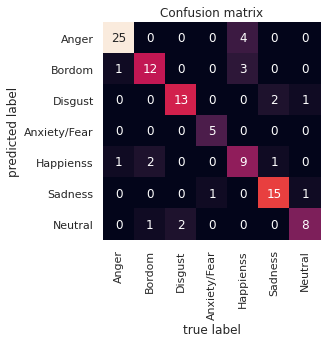

In [ ]:
# do the training using the kfold cross validation
kfold = KFold(n_splits=5, shuffle=True)
sum_acc3 = []
# data = np.array(data)
for train_index, test_index in kfold.split(data):  
  k = 0
  x = np.array(data.iloc[:, :-1])
  y_int = np.array(data.iloc[:, -1])

  # 2. encode labels to numerical values
  labelencoder = LabelEncoder()
  y_int = labelencoder.fit_transform(y_labels)

  onehot_encoder = OneHotEncoder(sparse=False)
  y_int = y_int.reshape(len(y_int),1)
  y_binary = onehot_encoder.fit_transform(y_int)
  y = y_binary

  x_train = x[train_index]
  y_train = y[train_index]
  x_test = x[test_index]
  y_test = y[test_index]

  # standard scaling the input features
  scaler = StandardScaler()
  scaler = scaler.fit(x_train)
  x_train = scaler.transform(x_train)
  x_test = scaler.transform(x_test)

  clear_output(wait=True)
  
  # 4. without using neither IP nor teacher forcing
  esn3 = ESN(x_train, y_train, IP=False, teacher_forcing=False)
  pred_train = esn3.esn_fit()
  # print('Training scores:')
  # esn3.score(y_train, pred_train)
  print('============================\n')

  pred_test3 = esn3.esn_predict(x_test)
  print('Testing scores:')
  sum_acc3.append(esn3.score(y_test, pred_test3)[1])
sum_acc3 = np.array(sum_acc3)
print(f'The accuracy of all {kfold.get_n_splits()} folds (cross validation) is:\n {sum_acc3}')
print(f'The mean of all accuracies is {np.mean(sum_acc3):.4f}%')
print('============================\n')

# get the index of the class with the highest probability
# because the confusion matrix accepts only 1d vector of digits
pred_test_index3 = argmax(pred_test3, axis=1)
y_test_index3 = argmax(y_test, axis=1)

emotion_range = ['Anger', 'Bordom', 'Disgust', 'Anxiety/Fear', 'Happienss', 'Sadness', 'Neutral']
mat = confusion_matrix(y_test_index3, pred_test_index3)
mat # this is the conv matrix
# create the heat map
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=emotion_range, yticklabels=emotion_range)

#ploting heatmap of confusion matrix
plt.title("Confusion matrix")
plt.xlabel('true label')
plt.ylabel('predicted label')


only IP....

only IP....
Testing scores:
The accuracy of all 5 folds (cross validation) is:
 [85.98130841 89.71962617 85.98130841 85.98130841 77.57009346]
The mean of all accuracies is 85.0467%



Text(89.18, 0.5, 'predicted label')

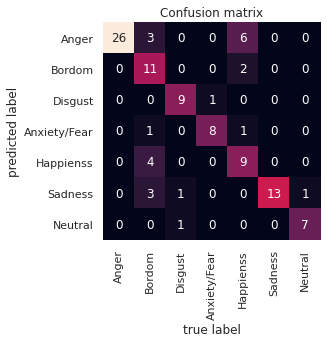

In [ ]:
# do the training using the kfold cross validation
kfold = KFold(n_splits=5, shuffle=True)
sum_acc = []
# data = np.array(data)
for train_index, test_index in kfold.split(data):  
  k = 0
  x = np.array(data.iloc[:, :-1])
  y_int = np.array(data.iloc[:, -1])

  # 2. encode labels to numerical values
  labelencoder = LabelEncoder()
  y_int = labelencoder.fit_transform(y_labels)

  onehot_encoder = OneHotEncoder(sparse=False)
  y_int = y_int.reshape(len(y_int),1)
  y_binary = onehot_encoder.fit_transform(y_int)
  y = y_binary

  x_train = x[train_index]
  y_train = y[train_index]
  x_test = x[test_index]
  y_test = y[test_index]

  # standard scaling the input features
  scaler = StandardScaler()
  scaler = scaler.fit(x_train)
  x_train = scaler.transform(x_train)
  x_test = scaler.transform(x_test)

  clear_output(wait=True)
  # 1. using only IP
  esn = ESN(x_train, y_train, teacher_forcing=False)
  pred_train = esn.esn_fit()
  # print(pred_train)
  # print('Training scores:')
  # esn.score(y_train, pred_train)
  print('============================\n')

  pred_test = esn.esn_predict(x_test)
  print('Testing scores:')
  sum_acc.append(esn.score(y_test, pred_test)[1])
sum_acc = np.array(sum_acc)
print(f'The accuracy of all {kfold.get_n_splits()} folds (cross validation) is:\n {sum_acc}')
print(f'The mean of all accuracies is {np.mean(sum_acc):.4f}%')
print('============================\n')

# get the index of the class with the highest probability
# because the confusion matrix accepts only 1d vector of digits
pred_test_index = argmax(pred_test, axis=1)
y_test_index = argmax(y_test, axis=1)

emotion_range = ['Anger', 'Bordom', 'Disgust', 'Anxiety/Fear', 'Happienss', 'Sadness', 'Neutral']
mat = confusion_matrix(y_test_index, pred_test_index)
mat # this is the conv matrix
# create the heat map
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=emotion_range, yticklabels=emotion_range)


#ploting heatmap of confusion matrix
plt.title("Confusion matrix")
plt.xlabel('true label')
plt.ylabel('predicted label')
  

only teacher forcing....

only teacher forcing....
Testing scores:
The accuracy of all 5 folds (cross validation) is:
 [88.78504673 87.85046729 82.24299065 80.37383178 84.11214953]
The mean of all accuracies is 84.6729%



Text(89.18, 0.5, 'predicted label')

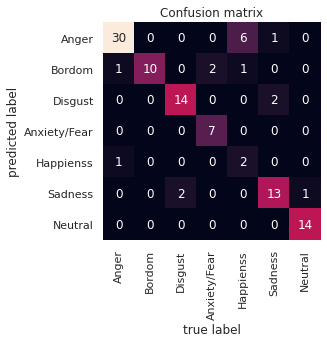

In [ ]:
# do the training using the kfold cross validation
kfold = KFold(n_splits=5, shuffle=True)
sum_acc1 = []
# data = np.array(data)
for train_index, test_index in kfold.split(data):  
  k = 0
  x = np.array(data.iloc[:, :-1])
  y_int = np.array(data.iloc[:, -1])

  # 2. encode labels to numerical values
  labelencoder = LabelEncoder()
  y_int = labelencoder.fit_transform(y_labels)

  onehot_encoder = OneHotEncoder(sparse=False)
  y_int = y_int.reshape(len(y_int),1)
  y_binary = onehot_encoder.fit_transform(y_int)
  y = y_binary

  x_train = x[train_index]
  y_train = y[train_index]
  x_test = x[test_index]
  y_test = y[test_index]

  # standard scaling the input features
  scaler = StandardScaler()
  scaler = scaler.fit(x_train)
  x_train = scaler.transform(x_train)
  x_test = scaler.transform(x_test)

  clear_output(wait=True)

  # 2. using only teacher forcing
  esn1 = ESN(x_train, y_train, IP=False)
  pred_train1 = esn1.esn_fit()
  # print('Training scores:')
  # esn1.score(y_train, pred_train1)
  print('============================\n')

  pred_test1 = esn1.esn_predict(x_test)
  print('Testing scores:')
  sum_acc1.append(esn1.score(y_test, pred_test1)[1])
sum_acc1 = np.array(sum_acc1)
print(f'The accuracy of all {kfold.get_n_splits()} folds (cross validation) is:\n {sum_acc1}')
print(f'The mean of all accuracies is {np.mean(sum_acc1):.4f}%')
print('============================\n')


# get the index of the class with the highest probability
# because the confusion matrix accepts only 1d vector of digits
pred_test_index1 = argmax(pred_test1, axis=1)
y_test_index1 = argmax(y_test, axis=1)

emotion_range = ['Anger', 'Bordom', 'Disgust', 'Anxiety/Fear', 'Happienss', 'Sadness', 'Neutral']
mat = confusion_matrix(y_test_index1, pred_test_index1)
mat # this is the conv matrix
# create the heat map
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=emotion_range, yticklabels=emotion_range)

#ploting heatmap of confusion matrix
plt.title("Confusion matrix")
plt.xlabel('true label')
plt.ylabel('predicted label')


with IP and teacher forcing....

with IP and teacher forcing....
Testing scores:
The accuracy of all 5 folds (cross validation) is:
 [92.52336449 80.37383178 82.24299065 85.04672897 85.04672897]
The mean of all accuracies is 85.0467%



Text(89.18, 0.5, 'predicted label')

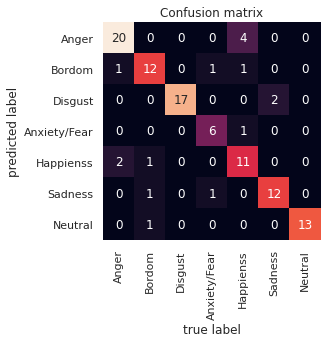

In [ ]:
# do the training using the kfold cross validation
kfold = KFold(n_splits=5, shuffle=True)
sum_acc2 = []
# data = np.array(data)
for train_index, test_index in kfold.split(data):  
  k = 0
  x = np.array(data.iloc[:, :-1])
  y_int = np.array(data.iloc[:, -1])

  # 2. encode labels to numerical values
  labelencoder = LabelEncoder()
  y_int = labelencoder.fit_transform(y_labels)

  onehot_encoder = OneHotEncoder(sparse=False)
  y_int = y_int.reshape(len(y_int),1)
  y_binary = onehot_encoder.fit_transform(y_int)
  y = y_binary

  x_train = x[train_index]
  y_train = y[train_index]
  x_test = x[test_index]
  y_test = y[test_index]

  # standard scaling the input features
  scaler = StandardScaler()
  scaler = scaler.fit(x_train)
  x_train = scaler.transform(x_train)
  x_test = scaler.transform(x_test)

  clear_output(wait=True)

  # 3. using Both IP and teacher forcing
  esn2 = ESN(x_train, y_train)
  pred_train = esn2.esn_fit()
  # print('Training scores:')
  # esn2.score(y_train, pred_train)
  print('============================\n')

  pred_test2 = esn2.esn_predict(x_test)
  print('Testing scores:')
  sum_acc2.append(esn2.score(y_test, pred_test2)[1])
sum_acc2 = np.array(sum_acc2)
print(f'The accuracy of all {kfold.get_n_splits()} folds (cross validation) is:\n {sum_acc2}')
print(f'The mean of all accuracies is {np.mean(sum_acc2):.4f}%')
print('============================\n')

# get the index of the class with the highest probability
# because the confusion matrix accepts only 1d vector of digits
pred_test_index2 = argmax(pred_test2, axis=1)
y_test_index2 = argmax(y_test, axis=1)

emotion_range = ['Anger', 'Bordom', 'Disgust', 'Anxiety/Fear', 'Happienss', 'Sadness', 'Neutral']
mat = confusion_matrix(y_test_index2, pred_test_index2)
mat # this is the conv matrix
# create the heat map
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=emotion_range, yticklabels=emotion_range)

#ploting heatmap of confusion matrix
plt.title("Confusion matrix")
plt.xlabel('true label')
plt.ylabel('predicted label')
